In [2]:
%pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
import time
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import  StandardScaler, MinMaxScaler, RobustScaler


In [4]:
df=pd.read_csv('./WORKLOAD.tsv',sep='\t',decimal='.')
df = df.sample(n=15000)
pd.set_option('display.float_format', '{:.4f}'.format)
df.head()

,Unnamed: 0,DATE,TIME,CPU3,CPU2,IO_DISK1,IO_DISK2,IO_DISK3,READS_DISK1,READS_DISK2,READS_DISK3,WRITES_DISK1,WRITES_DISK2,WRITES_DISK3
92289,92289,2023-01-21,18:45:00,8.3508,10.9468,15,910,10,13.7010,8.8794,0.0000,3.8690,2399.6106,5493588.6126
196107,196107,2023-01-01,11:50:00,6.6197,0.0441,72,300,6,12.8458,3.6777,0.0000,47.6121,1624.5039,2403189.3191
50511,50511,2023-01-07,17:38:00,10.0273,5.0913,61,340,8,17.0931,9.0715,6077492.7263,40.1108,99536.6342,6157246.8602
262446,262446,2023-01-07,20:09:00,433.4194,0.3079,43,878,3,11.2958,3.3071,1133871.9565,3.9192,68.1042,984264.9106
278951,278951,2023-01-31,19:00:00,8.7949,29.6990,51,559,9,10.7178,4.2682,3.7996,0.2230,0.4634,266446.9498


In [5]:
df = df.rename(columns={
    'CPU3': 'CPU1'
})
allfeatures = ['CPU1', 'CPU2', 'IO_DISK1', 'IO_DISK2', 'IO_DISK3', 'READS_DISK1', 'READS_DISK2', 'READS_DISK3', 'WRITES_DISK1', 'WRITES_DISK2', 'WRITES_DISK3']
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15000 entries, 92289 to 388932
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    15000 non-null  int64  
 1   DATE          15000 non-null  object 
 2   TIME          15000 non-null  object 
 3   CPU1          15000 non-null  float64
 4   CPU2          15000 non-null  float64
 5   IO_DISK1      15000 non-null  int64  
 6   IO_DISK2      15000 non-null  int64  
 7   IO_DISK3      15000 non-null  int64  
 8   READS_DISK1   15000 non-null  float64
 9   READS_DISK2   15000 non-null  float64
 10  READS_DISK3   15000 non-null  float64
 11  WRITES_DISK1  15000 non-null  float64
 12  WRITES_DISK2  15000 non-null  float64
 13  WRITES_DISK3  15000 non-null  float64
dtypes: float64(8), int64(4), object(2)
memory usage: 1.7+ MB


In [144]:
dt=df.describe()
dt=dt[allfeatures]
dt.loc['cv']=dt.loc['std'].values/dt.loc['mean'].values
dt.loc['range']=dt.loc['max'].values - dt.loc['min'].values
dt.loc['median'] = dt.median()
dt.loc['total'] = dt.sum()
dt.loc['variance'] = dt.var()
dt

,CPU1,CPU2,IO_DISK1,IO_DISK2,IO_DISK3,READS_DISK1,READS_DISK2,READS_DISK3,WRITES_DISK1,WRITES_DISK2,WRITES_DISK3
count,15000.0000,15000.0000,15000.0000,15000.0000,15000.0000,15000.0000,15000.0000,15000.0000,15000.0000,15000.0000,15000.0000
mean,19.4832,23.4355,53.3409,528.1659,6.4895,20.2259,20.3697,53325179754221889524858880.0000,12.9508,782133.7883,6009565.2734
std,73.3676,130.5730,27.1611,271.9326,2.2853,37.9818,362.3740,6497735025240322006562373632.0000,32.1900,39090702.7796,8825552.1485
min,6.3302,0.0018,7.0000,50.0000,3.0000,10.0001,3.2702,0.0000,0.0070,0.0000,61075.1360
25%,7.6605,1.0565,30.0000,295.0000,4.0000,11.5515,4.1618,0.0061,1.5929,0.6859,1560649.8764
50%,10.0679,3.7536,53.0000,528.0000,6.0000,14.1855,5.8921,161.2091,4.3638,20.5462,3273729.5920
75%,16.0750,13.4781,77.0000,764.0000,8.0000,20.0478,10.4418,2961735.8034,12.0261,622.9218,6847344.2990
max,5387.7023,8377.8009,100.0000,1000.0000,10.0000,2546.5542,37183.2352,795801351982491727878430916608.0000,1069.2968,4562697497.5332,189172772.3893
cv,3.7657,5.5716,0.5092,0.5149,0.3522,1.8779,17.7899,121.8512,2.4856,49.9796,1.4686
range,5381.3721,8377.7991,93.0000,950.0000,7.0000,2536.5541,37179.9650,795801351982491727878430916608.0000,1069.2898,4562697497.5332,189111697.2533


In [7]:
df_alt = df.sort_values(by="READS_DISK3", ascending=False)
df_alt.head()

,Unnamed: 0,DATE,TIME,CPU1,CPU2,IO_DISK1,IO_DISK2,IO_DISK3,READS_DISK1,READS_DISK2,READS_DISK3,WRITES_DISK1,WRITES_DISK2,WRITES_DISK3
167586,167586,2023-01-08,14:58:00,6.4845,1.1797,38,609,3,25.4693,7.5547,795801351982491727878430916608.0000,1.0747,296.8083,2335245.9908
17430,17430,2023-01-26,07:16:00,7.5380,2.2909,46,821,3,12.4323,4.7692,2911785379920614135728963584.0000,410.3669,3.0528,584277.8034
468952,468952,2023-01-20,15:03:00,142.4708,2.0704,12,375,8,18.2870,6.1505,649972397850622391736074240.0000,1.4087,4842.3634,15870341.7493
416957,416957,2023-01-17,10:26:00,29.1480,8.7512,92,149,7,11.2601,12.1328,350371216354441003639242752.0000,0.9219,36.4969,9866415.7208
397284,397284,2023-01-21,18:31:00,9.7634,26.7739,50,642,9,16.2156,300.3184,156158172399459987586285568.0000,0.3507,12.1556,7431977.4045


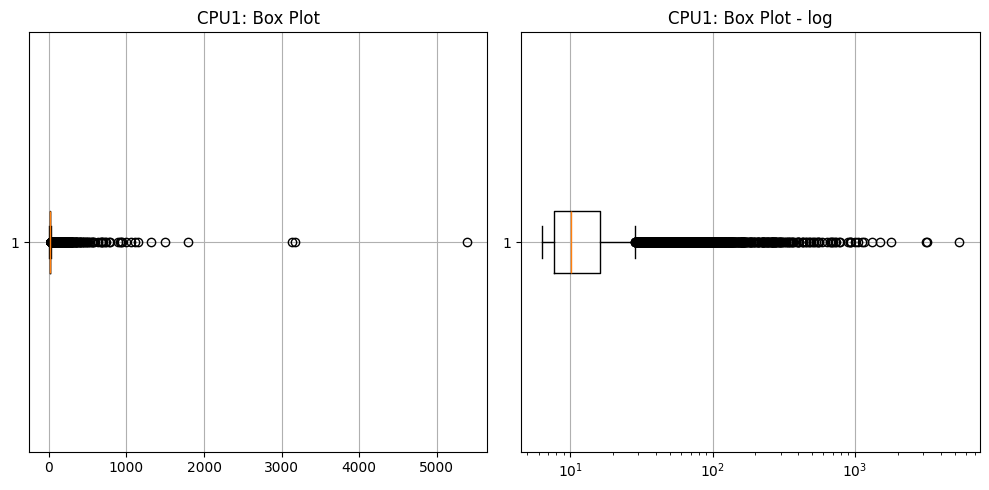

In [8]:
# Create a subplot with 1 row and 2 columns
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
# First box plot with outliers
axs[0].boxplot(df['CPU1'], vert=False)
axs[0].grid(True, zorder=10)
axs[0].set_title('CPU1: Box Plot')

# Second box plot without outliers
axs[1].boxplot(df['CPU1'], vert=False)
axs[1].grid(True, zorder=10)
axs[1].set_title('CPU1: Box Plot - log')
axs[1].set_xscale('log')

# Show the plot
plt.tight_layout()
plt.savefig(f"./p3/cpu1_bloxpot.png", dpi=300)  # Increase the resolution
plt.show()

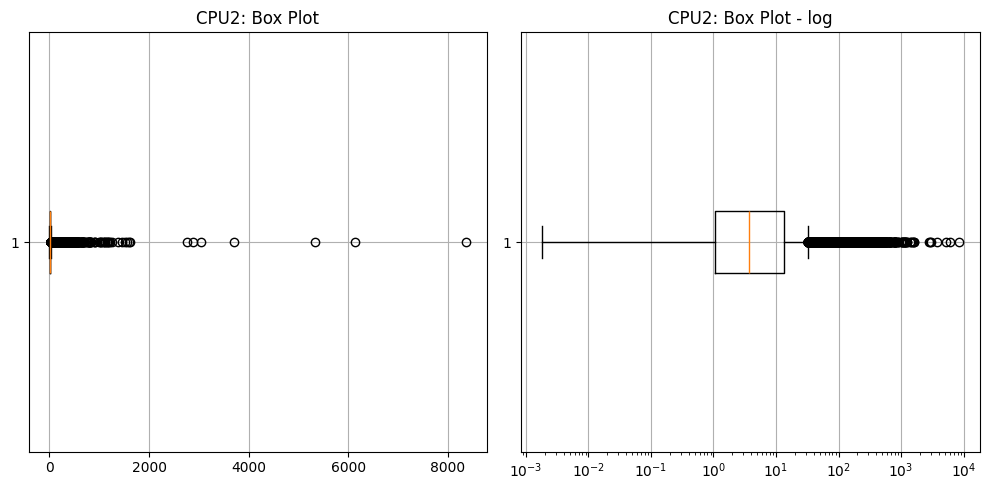

In [9]:
# Create a subplot with 1 row and 2 columns
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# First box plot with outliers
axs[0].boxplot(df['CPU2'], vert=False)
axs[0].grid(True, zorder=10)
axs[0].set_title('CPU2: Box Plot')

# Second box plot without outliers
axs[1].boxplot(df['CPU2'], vert=False)
axs[1].grid(True, zorder=10)
axs[1].set_title('CPU2: Box Plot - log')
axs[1].set_xscale('log')

# Show the plot
plt.tight_layout()
plt.savefig(f"./p3/cpu2_bloxpot.png", dpi=300)  # Increase the resolution
plt.show()

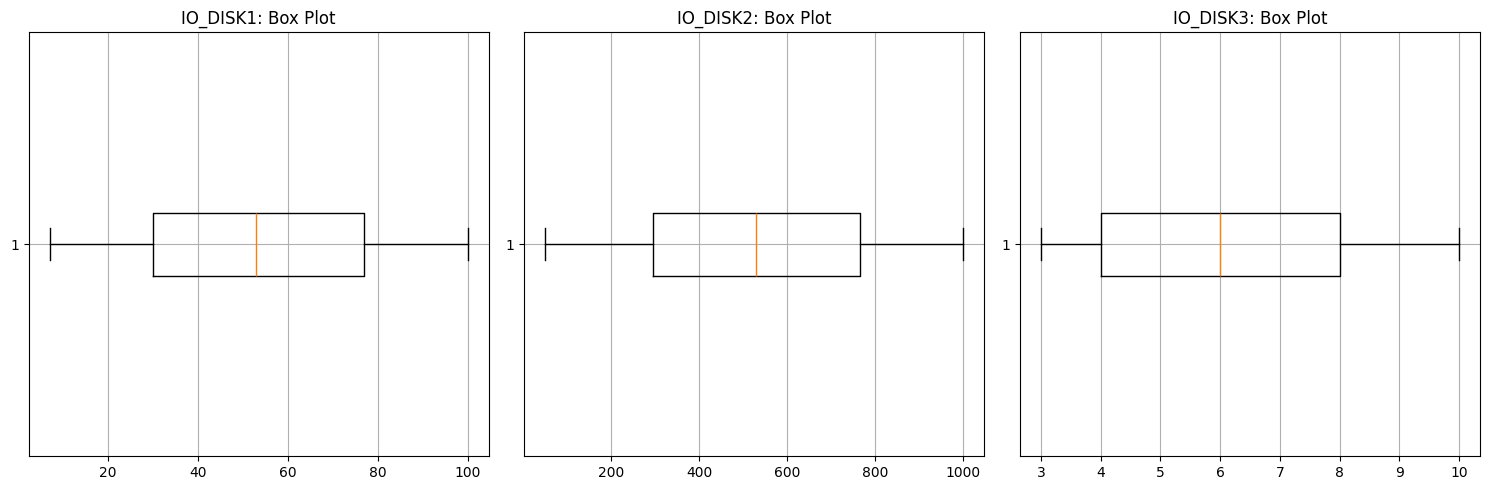

In [10]:
# Create a subplot with 1 row and 2 columns
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

# First box plot 
axs[0].boxplot(df['IO_DISK1'], vert=False)
axs[0].grid(True, zorder=10)
axs[0].set_title('IO_DISK1: Box Plot')

# Second box plot
axs[1].boxplot(df['IO_DISK2'], vert=False)
axs[1].grid(True, zorder=10)
axs[1].set_title('IO_DISK2: Box Plot')

# Third box plot
axs[2].boxplot(df['IO_DISK3'], vert=False)
axs[2].grid(True, zorder=10)
axs[2].set_title('IO_DISK3: Box Plot')

# Show the plot
plt.tight_layout()
plt.savefig(f"./p3/iodiskS_bloxpot.png", dpi=300)  # Increase the resolution
plt.show()

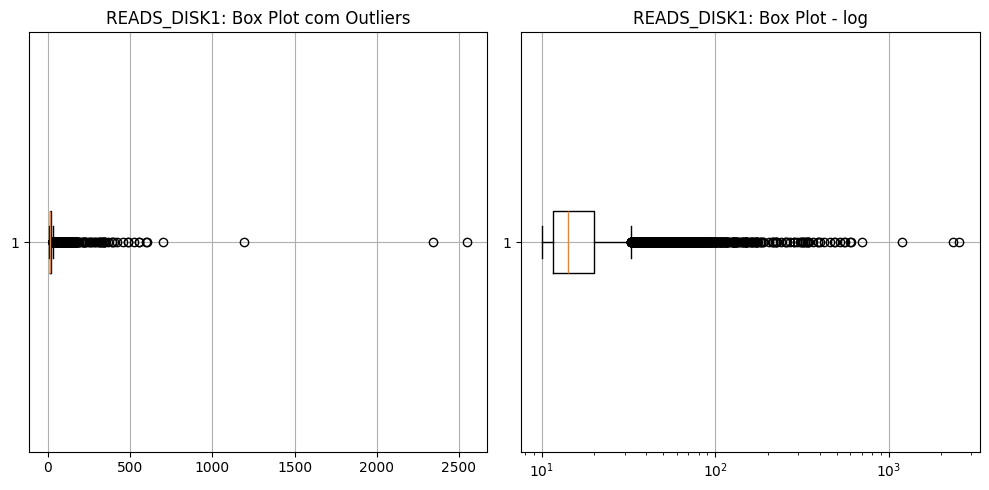

In [11]:
# Create a subplot with 1 row and 2 columns
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# First box plot with outliers
axs[0].boxplot(df['READS_DISK1'], vert=False)
axs[0].grid(True, zorder=10)
axs[0].set_title('READS_DISK1: Box Plot com Outliers')

# Second box plot without outliers
axs[1].boxplot(df['READS_DISK1'], vert=False)
axs[1].grid(True, zorder=10)
axs[1].set_title('READS_DISK1: Box Plot - log')
axs[1].set_xscale('log')


# Show the plot
plt.tight_layout()
plt.savefig(f"./p3/readsdisk1_bloxpot.png", dpi=300)  # Increase the resolution
plt.show()

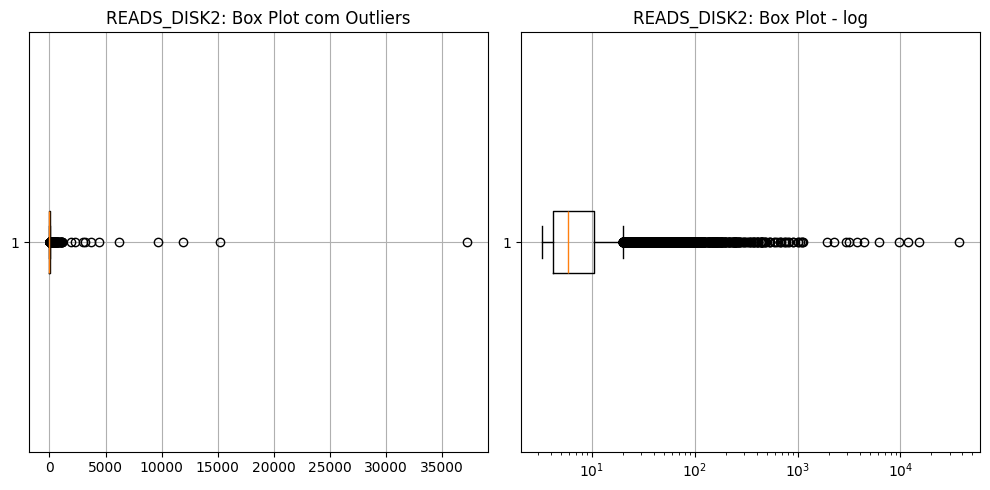

In [12]:
# Create a subplot with 1 row and 2 columns
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# First box plot with outliers
axs[0].boxplot(df['READS_DISK2'], vert=False)
axs[0].grid(True, zorder=10)
axs[0].set_title('READS_DISK2: Box Plot com Outliers')

# Second box plot without outliers
axs[1].boxplot(df['READS_DISK2'], vert=False)
axs[1].grid(True, zorder=10)
axs[1].set_title('READS_DISK2: Box Plot - log')
axs[1].set_xscale('log')

# Show the plot
plt.tight_layout()
plt.savefig(f"./p3/readsdisk2_bloxpot.png", dpi=300)  # Increase the resolution
plt.show()

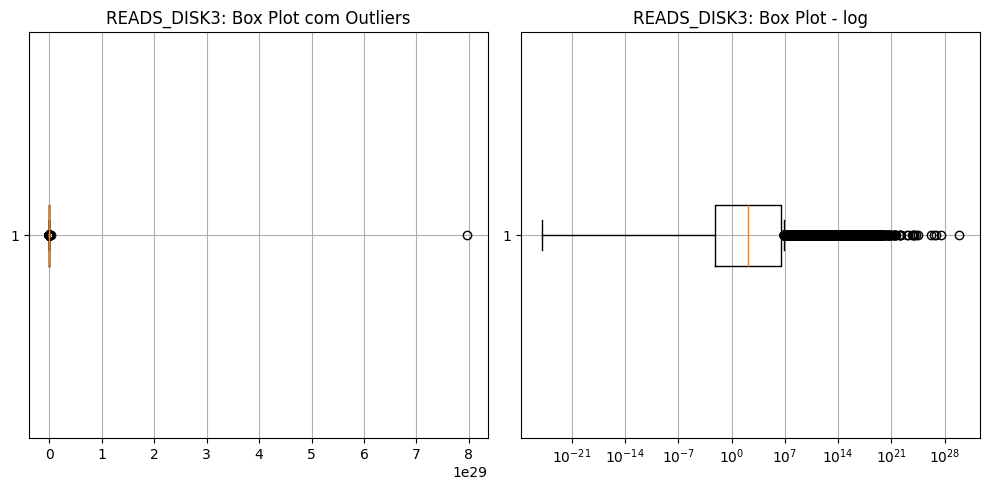

In [13]:
# Create a subplot with 1 row and 2 columns
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# First box plot with outliers
axs[0].boxplot(df['READS_DISK3'], vert=False)
axs[0].grid(True, zorder=10)
axs[0].set_title('READS_DISK3: Box Plot com Outliers')

# Second box plot without outliers
axs[1].boxplot(df['READS_DISK3'], vert=False)
axs[1].grid(True, zorder=10)
axs[1].set_title('READS_DISK3: Box Plot - log')
axs[1].set_xscale('log')

# Show the plot
plt.tight_layout()
plt.savefig(f"./p3/readsdisk3_bloxpot.png", dpi=300)  # Increase the resolution
plt.show()

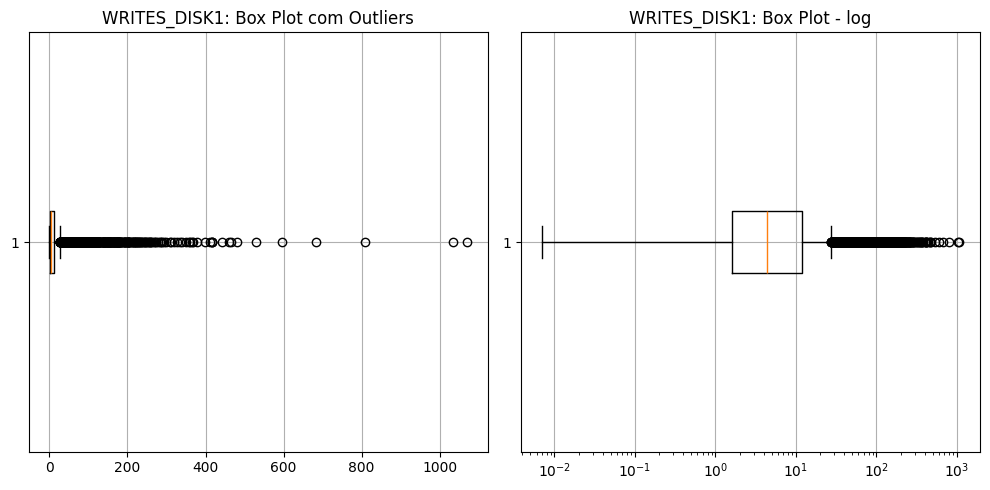

In [14]:
# Create a subplot with 1 row and 2 columns
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# First box plot with outliers
axs[0].boxplot(df['WRITES_DISK1'], vert=False)
axs[0].grid(True, zorder=10)
axs[0].set_title('WRITES_DISK1: Box Plot com Outliers')

# Second box plot without outliers
axs[1].boxplot(df['WRITES_DISK1'], vert=False)
axs[1].grid(True, zorder=10)
axs[1].set_title('WRITES_DISK1: Box Plot - log')
axs[1].set_xscale('log')

# Show the plot
plt.tight_layout()
plt.savefig(f"./p3/writesdisk1_bloxpot.png", dpi=300)  # Increase the resolution
plt.show()

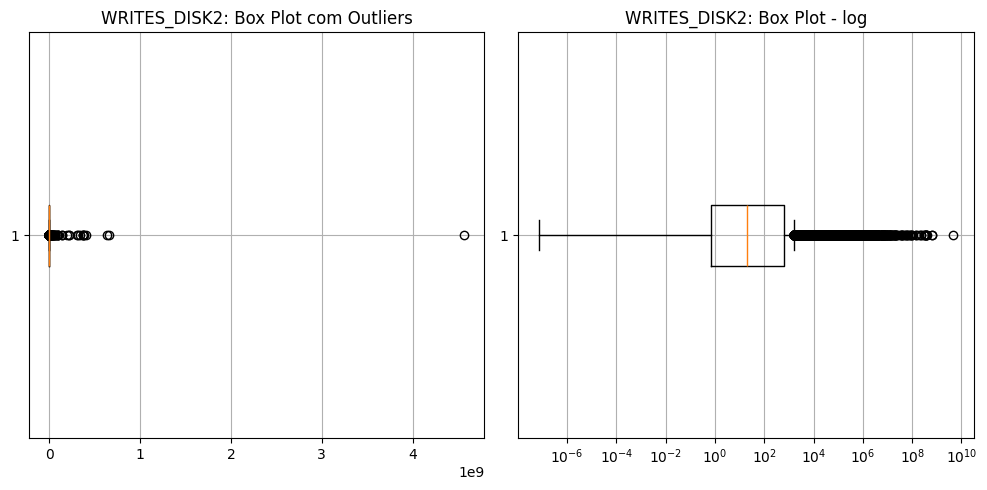

In [15]:
# Create a subplot with 1 row and 2 columns
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# First box plot with outliers
axs[0].boxplot(df['WRITES_DISK2'], vert=False)
axs[0].grid(True, zorder=10)
axs[0].set_title('WRITES_DISK2: Box Plot com Outliers')

# Second box plot without outliers
axs[1].boxplot(df['WRITES_DISK2'], vert=False)
axs[1].grid(True, zorder=10)
axs[1].set_title('WRITES_DISK2: Box Plot - log')
axs[1].set_xscale('log')

# Show the plot
plt.tight_layout()
plt.savefig(f"./p3/writesdisk2_bloxpot.png", dpi=300)  # Increase the resolution
plt.show()

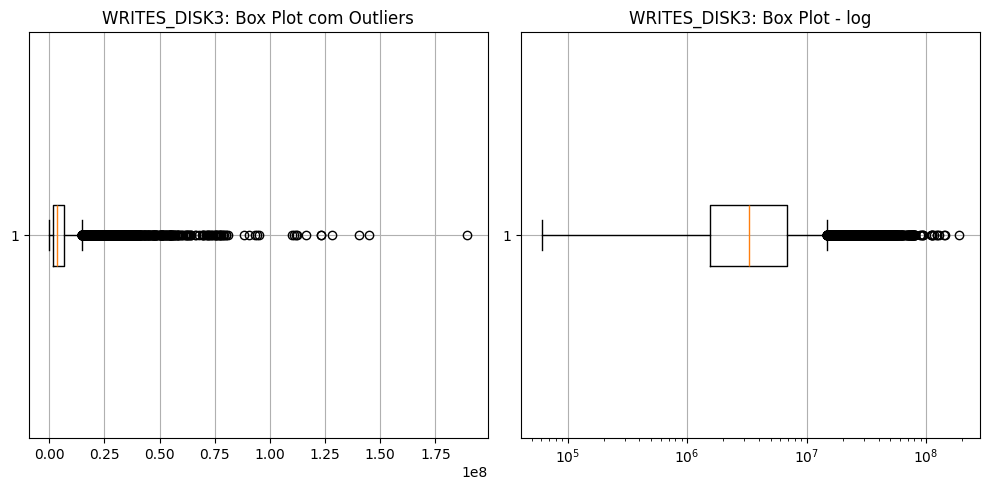

In [16]:
# Create a subplot with 1 row and 2 columns
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# First box plot with outliers
axs[0].boxplot(df['WRITES_DISK3'], vert=False)
axs[0].grid(True, zorder=10)
axs[0].set_title('WRITES_DISK3: Box Plot com Outliers')

# Second box plot without outliers
axs[1].boxplot(df['WRITES_DISK3'], vert=False)
axs[1].grid(True, zorder=10)
axs[1].set_title('WRITES_DISK3: Box Plot - log')
axs[1].set_xscale('log')

# Show the plot
plt.tight_layout()
plt.savefig(f"./p3/writesdisk3_bloxpot.png", dpi=300)  # Increase the resolution
plt.show()

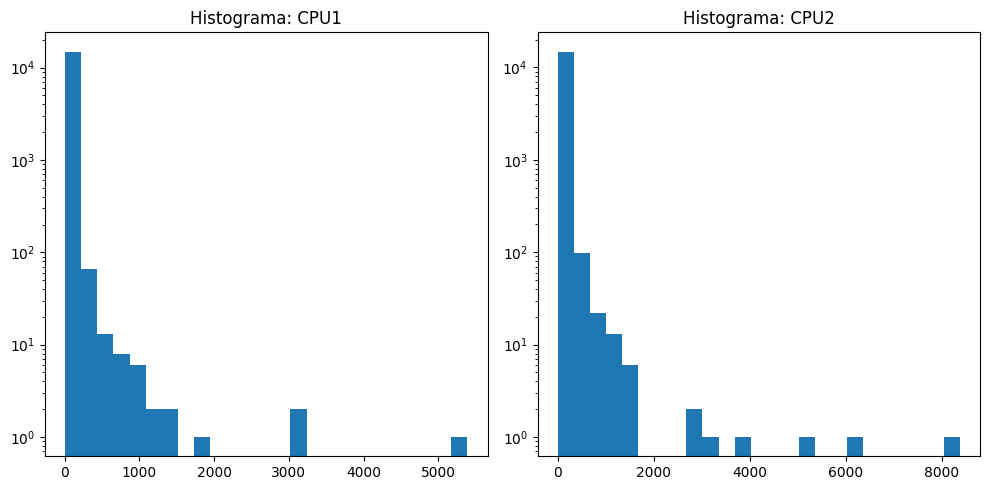

In [17]:
# Create a subplot with 1 row and 2 columns
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# First box plot with outliers
axs[0].hist(df['CPU1'], bins=25, log=True)
axs[0].set_title('Histograma: CPU1')

# First box plot with outliers
axs[1].hist(df['CPU2'], bins=25, log=True)
axs[1].set_title('Histograma: CPU2')

# Show the plot
plt.tight_layout()
plt.savefig(f"./p3/cpus_hist.png", dpi=300)  # Increase the resolution
plt.show()

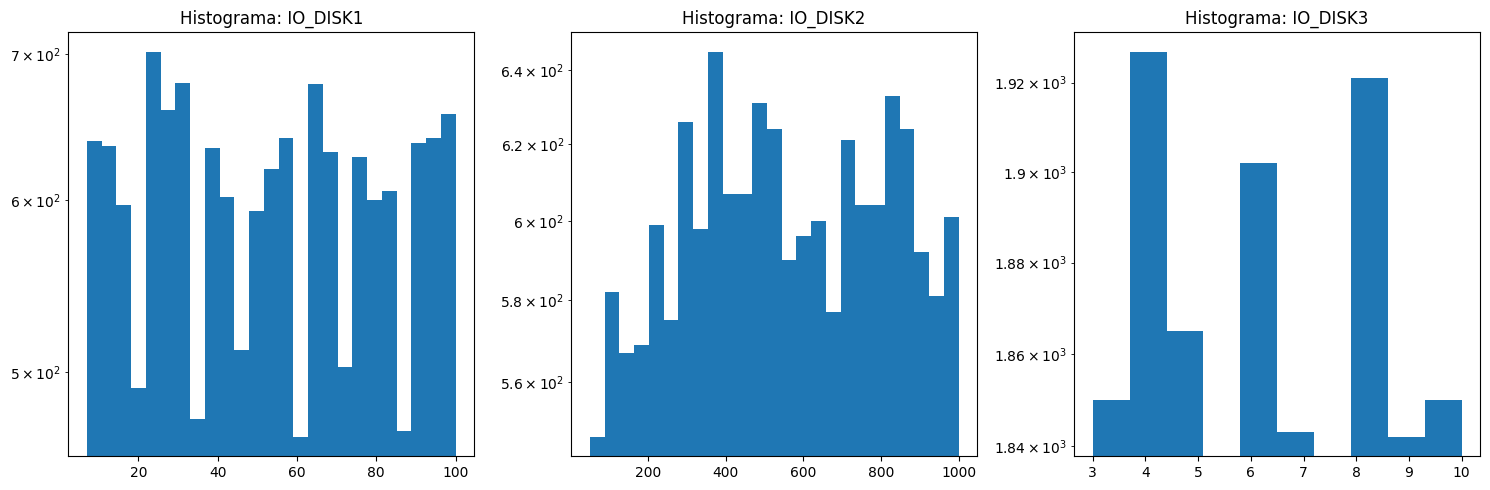

In [18]:
# Create a subplot with 1 row and 2 columns
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

# First box plot with outliers
axs[0].hist(df['IO_DISK1'], bins=25, log=True)
axs[0].set_title('Histograma: IO_DISK1')

# First box plot with outliers
axs[1].hist(df['IO_DISK2'], bins=25, log=True)
axs[1].set_title('Histograma: IO_DISK2')

# First box plot with outliers
axs[2].hist(df['IO_DISK3'], bins=10, log=True)
axs[2].set_title('Histograma: IO_DISK3')

# Show the plot
plt.tight_layout()
plt.savefig(f"./p3/ios_hist.png", dpi=300)  # Increase the resolution
plt.show()

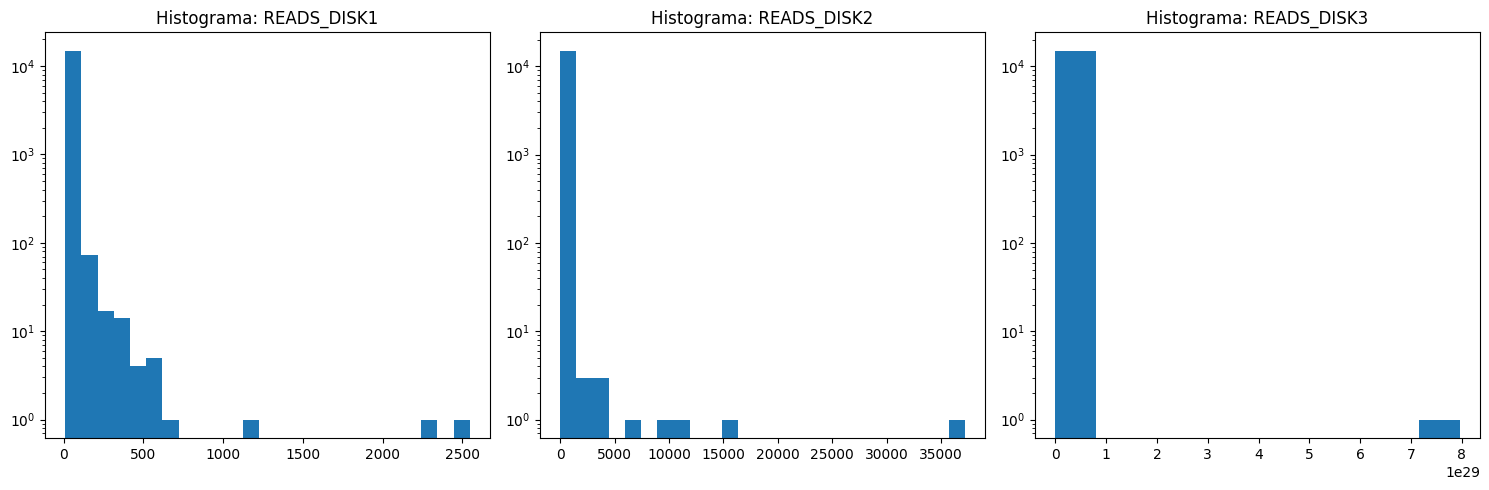

In [139]:
# Create a subplot with 1 row and 2 columns
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

# First box plot with outliers
axs[0].hist(df['READS_DISK1'], bins=25, log=True)
axs[0].set_title('Histograma: READS_DISK1')

# First box plot with outliers
axs[1].hist(df['READS_DISK2'], bins=25, log=True)
axs[1].set_title('Histograma: READS_DISK2')

# First box plot with outliers
axs[2].hist(df['READS_DISK3'], bins=10, log=True)
axs[2].set_title('Histograma: READS_DISK3')

# Show the plot
plt.tight_layout()
plt.savefig(f"./p3/reads_hist.png", dpi=300)  # Increase the resolution
plt.show()

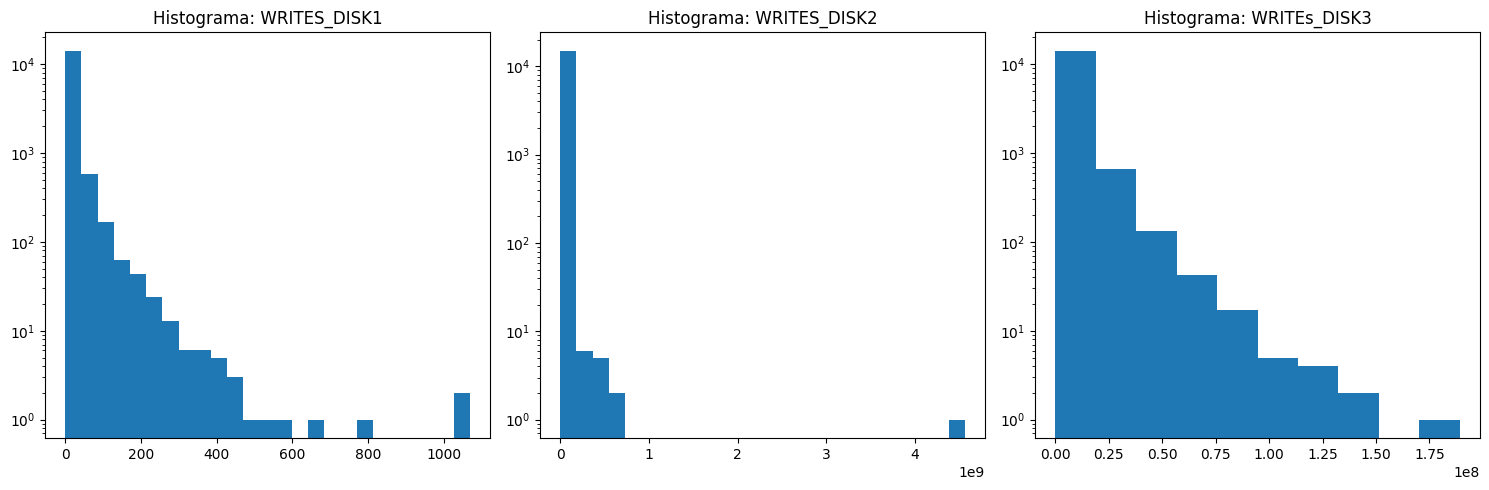

In [20]:
# Create a subplot with 1 row and 2 columns
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

# First box plot with outliers
axs[0].hist(df['WRITES_DISK1'], bins=25, log=True)
axs[0].set_title('Histograma: WRITES_DISK1')

# First box plot with outliers
axs[1].hist(df['WRITES_DISK2'], bins=25, log=True)
axs[1].set_title('Histograma: WRITES_DISK2')

# First box plot with outliers
axs[2].hist(df['WRITES_DISK3'], bins=10, log=True)
axs[2].set_title('Histograma: WRITEs_DISK3')

# Show the plot
plt.tight_layout()
plt.savefig(f"./p3/writes_hist.png", dpi=300)  # Increase the resolution
plt.show()

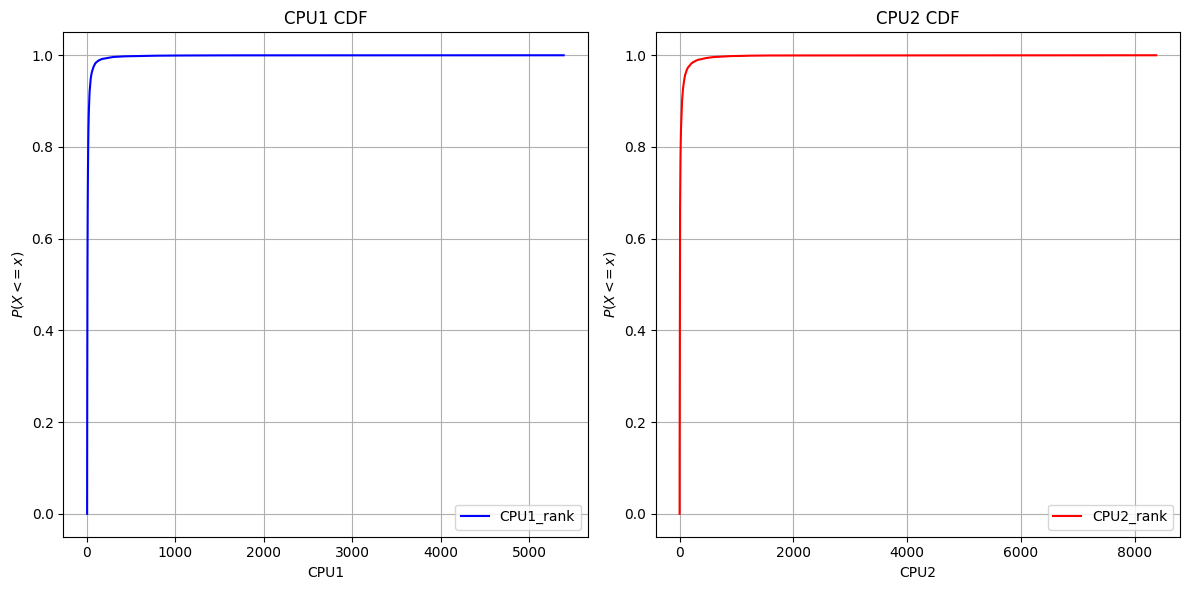

In [21]:
df['CPU1_rank'] = df['CPU1'].rank(method = 'average', pct = True)
df['CPU2_rank'] = df['CPU2'].rank(method = 'average', pct = True)

# Create subplots
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Plot for CPU1
df.sort_values('CPU1').plot(x='CPU1', y='CPU1_rank', grid=True, color='blue', ax=axs[0])
axs[0].set_title('CPU1 CDF')
axs[0].set_ylabel(r"$P(X <\!\!= x)$")

# Plot for CPU2
df.sort_values('CPU2').plot(x='CPU2', y='CPU2_rank', grid=True, color='red', ax=axs[1])
axs[1].set_title('CPU2 CDF')
axs[1].set_ylabel(r"$P(X <\!\!= x)$")

# Adjust layout and save the plot
plt.tight_layout()
plt.savefig("./p3/cpus_cdf.png", dpi=300)  # Save figure
plt.show()

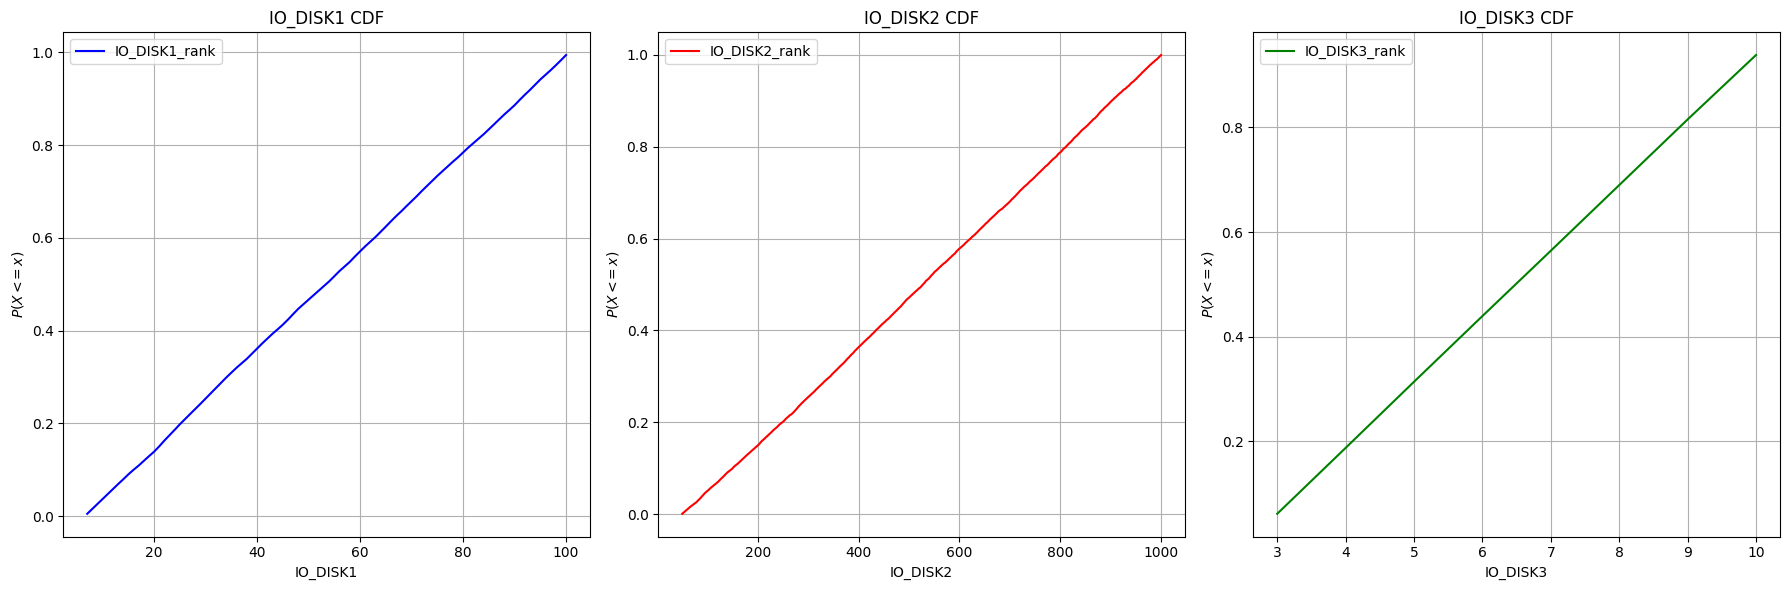

In [22]:
df['IO_DISK1_rank'] = df['IO_DISK1'].rank(method = 'average', pct = True)
df['IO_DISK2_rank'] = df['IO_DISK2'].rank(method = 'average', pct = True)
df['IO_DISK3_rank'] = df['IO_DISK3'].rank(method = 'average', pct = True)

# Create subplots
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

# Plot for IO_DISK1
df.sort_values('IO_DISK1').plot(x='IO_DISK1', y='IO_DISK1_rank', grid=True, color='blue', ax=axs[0])
axs[0].set_title('IO_DISK1 CDF')
axs[0].set_ylabel(r"$P(X <\!\!= x)$")

# Plot for IO_DISK2
df.sort_values('IO_DISK2').plot(x='IO_DISK2', y='IO_DISK2_rank', grid=True, color='red', ax=axs[1])
axs[1].set_title('IO_DISK2 CDF')
axs[1].set_ylabel(r"$P(X <\!\!= x)$")

# Plot for IO_DISK3
df.sort_values('IO_DISK3').plot(x='IO_DISK3', y='IO_DISK3_rank', grid=True, color='green', ax=axs[2])
axs[2].set_title('IO_DISK3 CDF')
axs[2].set_ylabel(r"$P(X <\!\!= x)$")

# Adjust layout and save the plot
plt.tight_layout()
plt.savefig("./p3/ios_cdf.png", dpi=300)  # Save figure
plt.show()

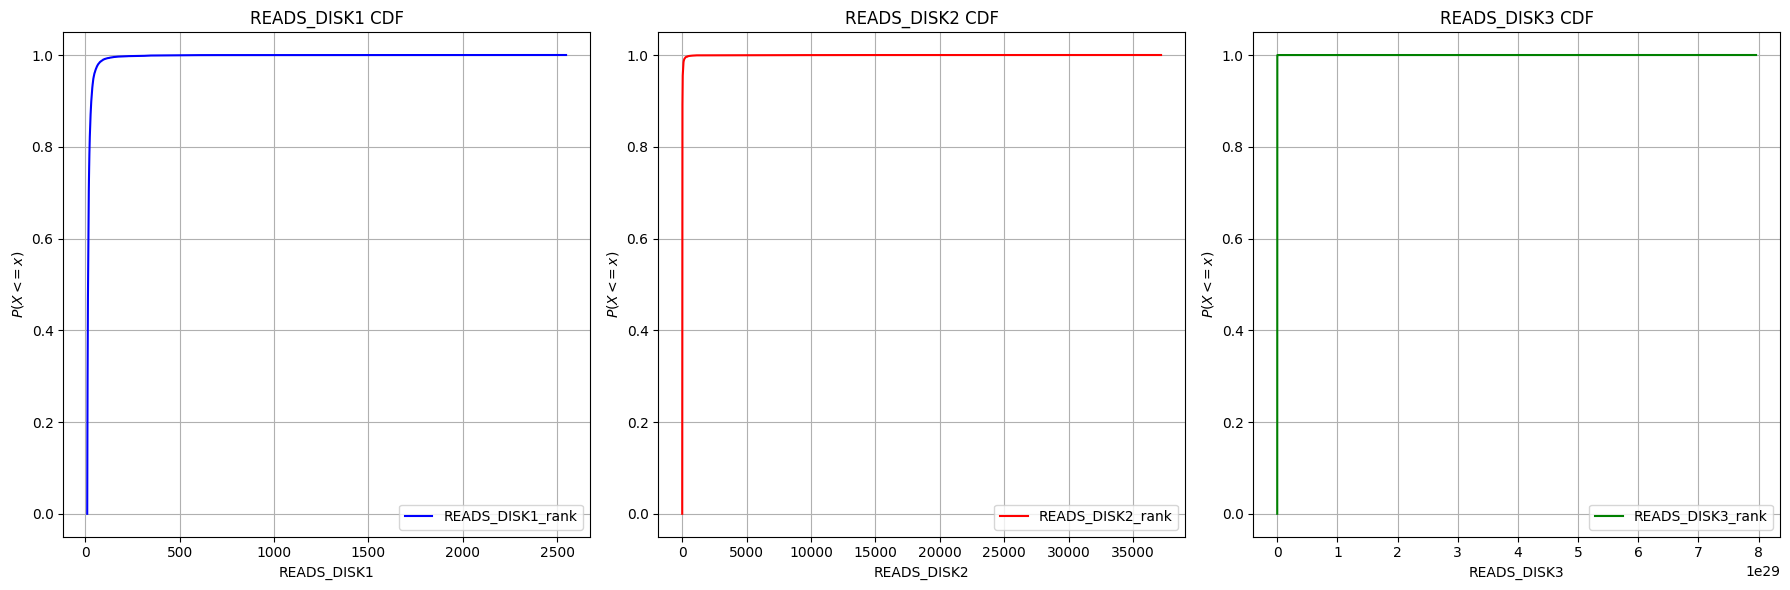

In [23]:
df['READS_DISK1_rank'] = df['READS_DISK1'].rank(method = 'average', pct = True)
df['READS_DISK2_rank'] = df['READS_DISK2'].rank(method = 'average', pct = True)
df['READS_DISK3_rank'] = df['READS_DISK3'].rank(method = 'average', pct = True)

# Create subplots
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

# Plot for READS_DISK1
df.sort_values('READS_DISK1').plot(x='READS_DISK1', y='READS_DISK1_rank', grid=True, color='blue', ax=axs[0])
axs[0].set_title('READS_DISK1 CDF')
axs[0].set_ylabel(r"$P(X <\!\!= x)$")

# Plot for READS_DISK2
df.sort_values('READS_DISK2').plot(x='READS_DISK2', y='READS_DISK2_rank', grid=True, color='red', ax=axs[1])
axs[1].set_title('READS_DISK2 CDF')
axs[1].set_ylabel(r"$P(X <\!\!= x)$")

# Plot for READS_DISK3
df.sort_values('READS_DISK3').plot(x='READS_DISK3', y='READS_DISK3_rank', grid=True, color='green', ax=axs[2])
axs[2].set_title('READS_DISK3 CDF')
axs[2].set_ylabel(r"$P(X <\!\!= x)$")

# Adjust layout and save the plot
plt.tight_layout()
plt.savefig("./p3/reads_cdf.png", dpi=300)  # Save figure
plt.show()

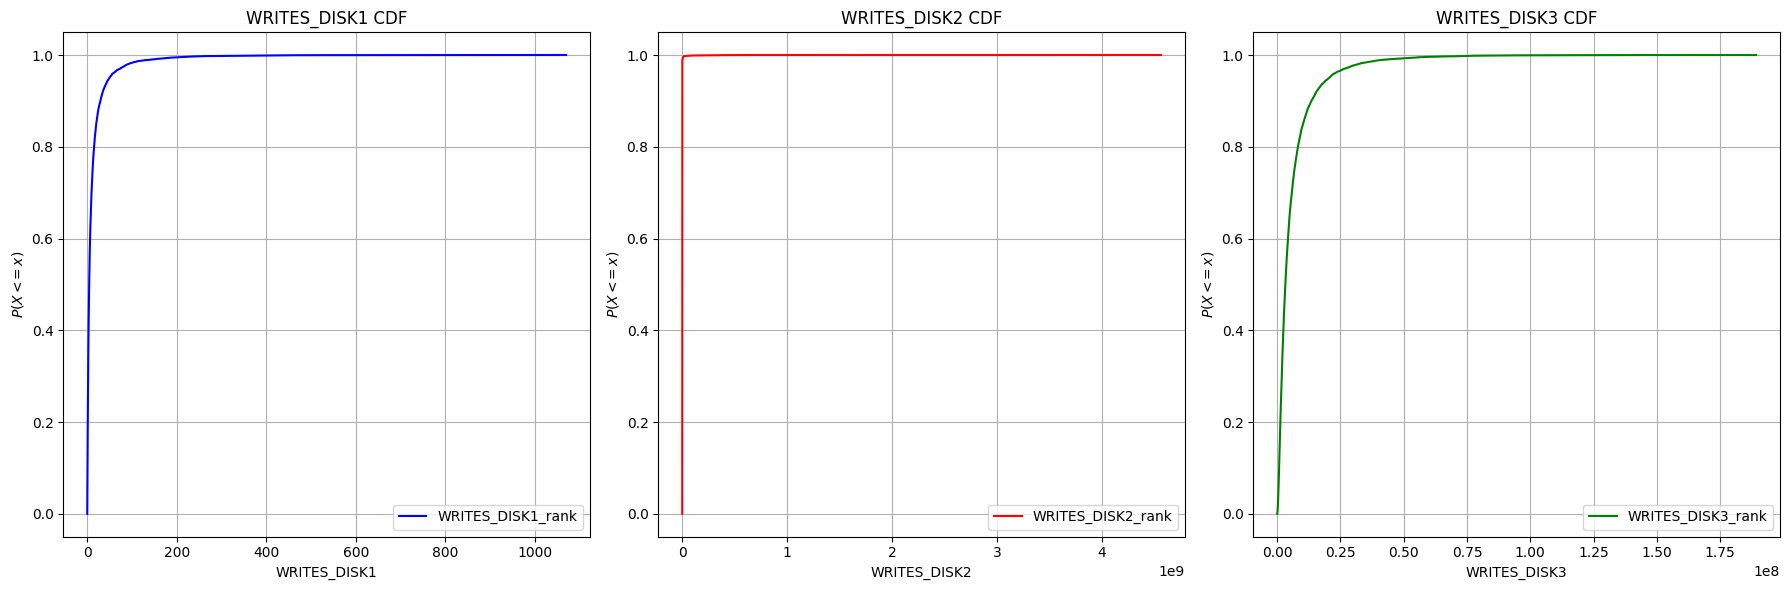

In [24]:
df['WRITES_DISK1_rank'] = df['WRITES_DISK1'].rank(method = 'average', pct = True)
df['WRITES_DISK2_rank'] = df['WRITES_DISK2'].rank(method = 'average', pct = True)
df['WRITES_DISK3_rank'] = df['WRITES_DISK3'].rank(method = 'average', pct = True)

# Create subplots
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

# Plot for WRITES_DISK1
df.sort_values('WRITES_DISK1').plot(x='WRITES_DISK1', y='WRITES_DISK1_rank', grid=True, color='blue', ax=axs[0])
axs[0].set_title('WRITES_DISK1 CDF')
axs[0].set_ylabel(r"$P(X <\!\!= x)$")

# Plot for WRITES_DISK2
df.sort_values('WRITES_DISK2').plot(x='WRITES_DISK2', y='WRITES_DISK2_rank', grid=True, color='red', ax=axs[1])
axs[1].set_title('WRITES_DISK2 CDF')
axs[1].set_ylabel(r"$P(X <\!\!= x)$")

# Plot for WRITES_DISK3
df.sort_values('WRITES_DISK3').plot(x='WRITES_DISK3', y='WRITES_DISK3_rank', grid=True, color='green', ax=axs[2])
axs[2].set_title('WRITES_DISK3 CDF')
axs[2].set_ylabel(r"$P(X <\!\!= x)$")

# Adjust layout and save the plot
plt.tight_layout()
plt.savefig("./p3/WRITES_cdf.png", dpi=300)  # Save figure
plt.show()

In [156]:
df['CPUS'] = df['CPU1'] + df['CPU2']
df['IO_DISKS'] = df['IO_DISK1'] + df['IO_DISK2'] + df['IO_DISK3'] 
df['READS_DISKS'] = df['READS_DISK1'] + df['READS_DISK2'] + df['READS_DISK3'] 
df['WRITES_DISKS'] = df['WRITES_DISK1'] + df['WRITES_DISK2'] + df['WRITES_DISK3']
clusterfeatures = ['CPUS', 'IO_DISKS', 'READS_DISKS', 'WRITES_DISKS']


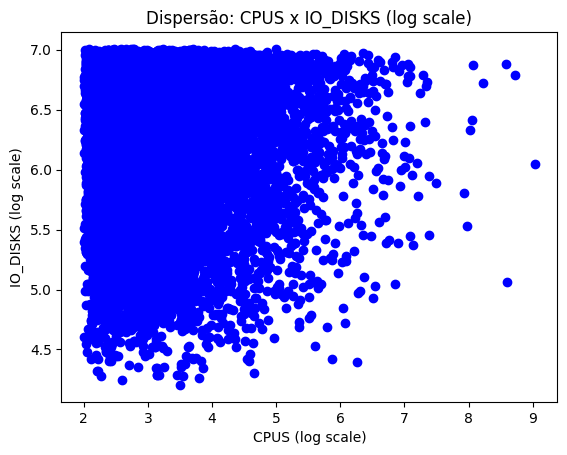

In [26]:
# Aplicar a transformação logarítmica
df['CPUS_log'] = np.log1p(df['CPUS'])
df['IO_DISKS_log'] = np.log1p(df['IO_DISKS'])

# Criar o gráfico de dispersão usando os dados transformados
plt.scatter(df['CPUS_log'], df['IO_DISKS_log'], color='blue')
plt.title('Dispersão: CPUS x IO_DISKS (log scale)')

plt.xlabel('CPUS (log scale)')
plt.ylabel('IO_DISKS (log scale)')

# Salvar a figura
plt.savefig(f"./p3/CPUSxIO_DISKS_log_scale.png", dpi=300)  # Aumentar a resolução
plt.show()


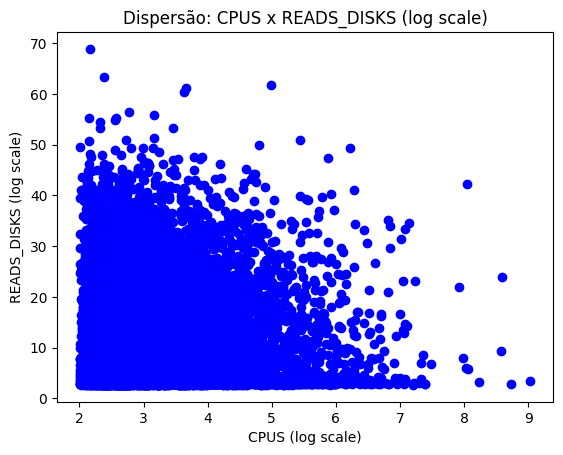

In [27]:
# Aplicar a transformação logarítmica
df['CPUS_log'] = np.log1p(df['CPUS'])
df['READS_DISKS_log'] = np.log1p(df['READS_DISKS'])

# Criar o gráfico de dispersão usando os dados transformados
plt.scatter(df['CPUS_log'], df['READS_DISKS_log'], color='blue')
plt.title('Dispersão: CPUS x READS_DISKS (log scale)')

plt.xlabel('CPUS (log scale)')
plt.ylabel('READS_DISKS (log scale)')

# Salvar a figura
plt.savefig(f"./p3/CPUSxREADS_DISKS_log_scale.png", dpi=300)  # Aumentar a resolução
plt.show()


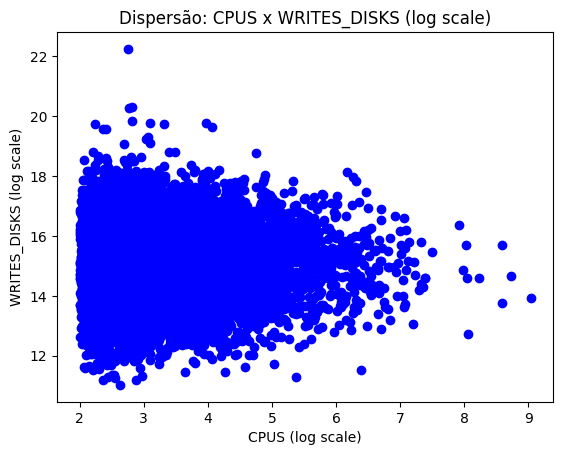

In [28]:
# Aplicar a transformação logarítmica
df['CPUS_log'] = np.log1p(df['CPUS'])
df['WRITES_DISKS_log'] = np.log1p(df['WRITES_DISKS'])

# Criar o gráfico de dispersão usando os dados transformados
plt.scatter(df['CPUS_log'], df['WRITES_DISKS_log'], color='blue')
plt.title('Dispersão: CPUS x WRITES_DISKS (log scale)')

plt.xlabel('CPUS (log scale)')
plt.ylabel('WRITES_DISKS (log scale)')

# Salvar a figura
plt.savefig(f"./p3/CPUSxWRITES_DISKS_log_scale.png", dpi=300)  # Aumentar a resolução
plt.show()


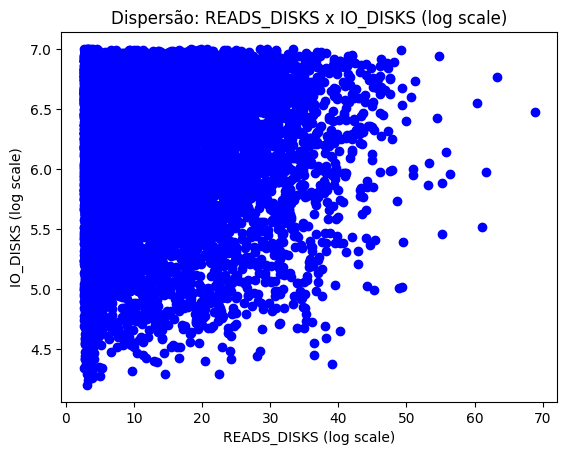

In [29]:
# Aplicar a transformação logarítmica
df['READS_DISKS_log'] = np.log1p(df['READS_DISKS'])
df['IO_DISKS_log'] = np.log1p(df['IO_DISKS'])

# Criar o gráfico de dispersão usando os dados transformados
plt.scatter(df['READS_DISKS_log'], df['IO_DISKS_log'], color='blue')
plt.title('Dispersão: READS_DISKS x IO_DISKS (log scale)')

plt.xlabel('READS_DISKS (log scale)')
plt.ylabel('IO_DISKS (log scale)')

# Salvar a figura
plt.savefig(f"./p3/READS_DISKSxIO_DISKS_log_scale.png", dpi=300)  # Aumentar a resolução
plt.show()


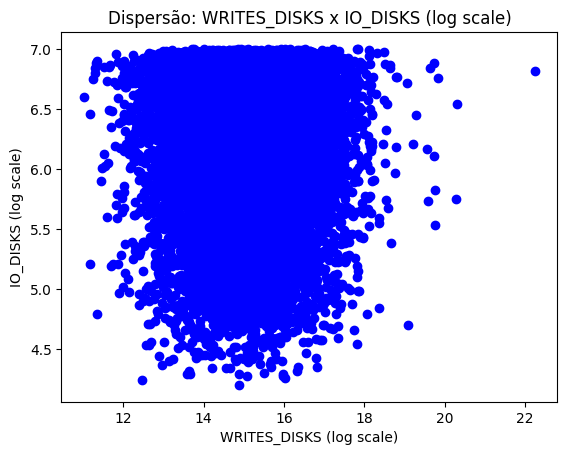

In [30]:
# Aplicar a transformação logarítmica
df['WRITES_DISKS_log'] = np.log1p(df['WRITES_DISKS'])
df['IO_DISKS_log'] = np.log1p(df['IO_DISKS'])

# Criar o gráfico de dispersão usando os dados transformados
plt.scatter(df['WRITES_DISKS_log'], df['IO_DISKS_log'], color='blue')
plt.title('Dispersão: WRITES_DISKS x IO_DISKS (log scale)')

plt.xlabel('WRITES_DISKS (log scale)')
plt.ylabel('IO_DISKS (log scale)')

# Salvar a figura
plt.savefig(f"./p3/WRITES_DISKSxIO_DISKS_log_scale.png", dpi=300)  # Aumentar a resolução
plt.show()


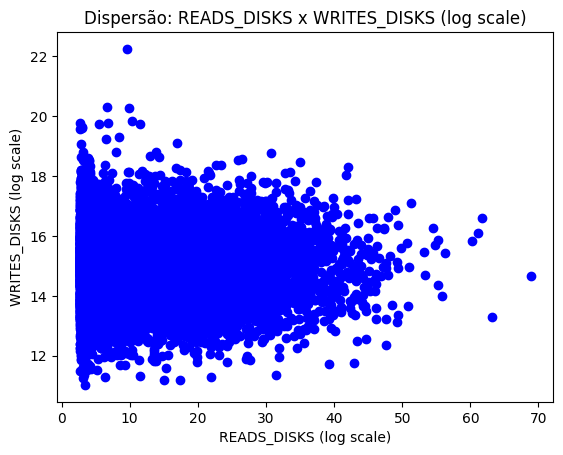

In [31]:
# Aplicar a transformação logarítmica
df['READS_DISKS_log'] = np.log1p(df['READS_DISKS'])
df['WRITES_DISKS_log'] = np.log1p(df['WRITES_DISKS'])

# Criar o gráfico de dispersão usando os dados transformados
plt.scatter(df['READS_DISKS_log'], df['WRITES_DISKS_log'], color='blue')
plt.title('Dispersão: READS_DISKS x WRITES_DISKS (log scale)')

plt.xlabel('READS_DISKS (log scale)')
plt.ylabel('WRITES_DISKS (log scale)')

# Salvar a figura
plt.savefig(f"./p3/READS_DISKSxWRITES_DISKS_log_scale.png", dpi=300)  # Aumentar a resolução
plt.show()


In [32]:
# Calculate max, min and the ratio for each of the specified columns
max_values = df[allfeatures].max()
min_values = df[allfeatures].min()
ratios = np.log(max_values) - np.log(min_values)

# Create a new DataFrame with max, min, and ratio rows
custom_df = pd.DataFrame([max_values, min_values, ratios], index=['max', 'min', 'ratio'])
custom_df

,CPU1,CPU2,IO_DISK1,IO_DISK2,IO_DISK3,READS_DISK1,READS_DISK2,READS_DISK3,WRITES_DISK1,WRITES_DISK2,WRITES_DISK3
max,5387.7023,8377.8009,100.0000,1000.0000,10.0000,2546.5542,37183.2352,795801351982491727878430916608.0000,1069.2968,4562697497.5332,189172772.3893
min,6.3302,0.0018,7.0000,50.0000,3.0000,10.0001,3.2702,0.0000,0.0070,0.0000,61075.1360
ratio,6.7465,15.3561,2.6593,2.9957,1.2040,5.5399,9.3388,126.2555,11.9356,38.6999,8.0383


In [33]:
# Verificar se há valores negativos em allfeatures
if (df[allfeatures] < 0).any().any():
    raise ValueError("Existem valores negativos nas características, que não são adequados para log1p.")


In [146]:
import numpy as np

# Apply log transformation to non-negative values in the DataFrame
df_transformed = df.copy()
df_transformed[allfeatures] = np.log1p(df_transformed[allfeatures])

dt_t=df_transformed.describe()
dt_t=dt_t[allfeatures]
dt_t.loc['cv']=dt_t.loc['std'].values/dt_t.loc['mean'].values
dt_t.loc['range']=dt_t.loc['max'].values - dt_t.loc['min'].values
dt_t.loc['median'] = dt_t.median()
dt_t.loc['total'] = dt_t.sum()
dt_t.loc['variance'] = dt_t.var()
dt_t


,CPU1,CPU2,IO_DISK1,IO_DISK2,IO_DISK3,READS_DISK1,READS_DISK2,READS_DISK3,WRITES_DISK1,WRITES_DISK2,WRITES_DISK3
count,15000.0000,15000.0000,15000.0000,15000.0000,15000.0000,15000.0000,15000.0000,15000.0000,15000.0000,15000.0000,15000.0000
mean,2.6081,1.8348,3.8248,6.0807,1.9626,2.8671,2.1749,8.8120,1.8438,3.9400,15.0024
std,0.6492,1.3766,0.6437,0.6950,0.3270,0.4794,0.7729,10.3362,1.1256,3.7531,1.1029
min,1.9920,0.0018,2.0794,3.9318,1.3863,2.3979,1.4517,0.0000,0.0070,0.0000,11.0199
25%,2.1588,0.7210,3.4340,5.6904,1.6094,2.5298,1.6413,0.0061,0.9528,0.5223,14.2606
50%,2.4041,1.5589,3.9890,6.2710,1.9459,2.7203,1.9304,5.0889,1.6797,3.0702,15.0014
75%,2.8376,2.6726,4.3567,6.6399,2.1972,3.0468,2.4373,14.9013,2.5670,6.4360,15.7394
max,8.5921,9.0335,4.6151,6.9088,2.3979,7.8429,10.5236,68.8491,6.9757,22.2412,19.0582
cv,0.2489,0.7503,0.1683,0.1143,0.1666,0.1672,0.3554,1.1730,0.6105,0.9526,0.0735
range,6.6001,9.0317,2.5357,2.9769,1.0116,5.4450,9.0720,68.8491,6.9687,22.2412,8.0383


In [147]:
pca = PCA(n_components=len(allfeatures))

X = df_transformed[allfeatures]
pca.fit(X)
X_pca = pca.transform(X)
 
pca.explained_variance_ratio_

array([8.37589256e-01, 1.10433839e-01, 1.48570757e-02, 9.97973074e-03,
       9.48059551e-03, 4.68450981e-03, 3.79121874e-03, 3.30185626e-03,
       3.24316707e-03, 1.80120207e-03, 8.37549641e-04])

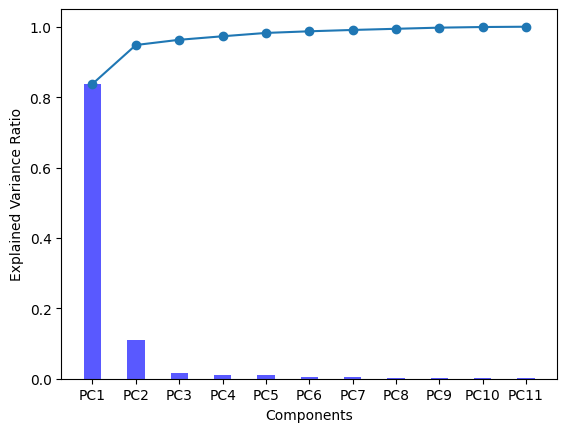

In [148]:
components=[ f"PC{i}" for i in range(1, len(pca.explained_variance_ratio_) + 1)]
explain_var_cum=np.cumsum(pca.explained_variance_ratio_)
plt.plot(components, explain_var_cum, marker='o')
plt.bar(components, pca.explained_variance_ratio_, color ='blue',
 width = 0.4, alpha=0.65)
plt.xlabel('Components')
plt.ylabel('Explained Variance Ratio')
plt.savefig(f"./p3/pca_components.png", dpi=300)  # Increase the resolution
plt.draw()

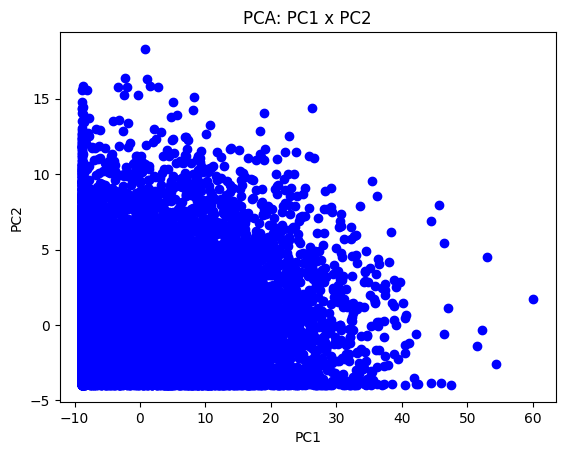

In [37]:
plt.scatter(X_pca[:, 0], X_pca[:, 1],color='blue')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA: PC1 x PC2')
plt.savefig(f"./p3/pc1xpc2.png", dpi=300)  # Increase the resolution
plt.draw()


In [38]:
scaler = StandardScaler() # Média 0 e Desvio Padrão 1: N(0,1).
scaler.fit(X_pca)
X_scaler = scaler.transform(X_pca)
X_scaler.mean(axis=0)

array([-4.12262816e-18,  4.77025826e-17,  1.18701345e-17, -2.82736797e-17,
        3.37063710e-17, -2.18084809e-17,  1.03620816e-19, -7.71975076e-18,
       -9.79216708e-18,  8.74855743e-18,  6.58732328e-18])

In [155]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import numpy as np
import time

# Considerando os dois primeiros componentes do PCA diretamente
X_scaler_reduced = X_scaler[:, :2]  # Utilizando apenas os dois primeiros componentes

lsilhouette = []
lknumber = range(2, 19)

for k in lknumber:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaler_reduced)  # Utilizando os componentes reduzidos do PCA

    # Rótulos de cada cluster
    cluster_labels = kmeans.labels_

    # Cálculo do índice de Silhouette utilizando os componentes reduzidos
    silhouette = silhouette_score(X_scaler_reduced, cluster_labels, metric='euclidean')
    
    # Armazenando no vetor o valor de cada índice
    lsilhouette.append(silhouette)

    print(f"K = {k}: {silhouette:.4f}")



K = 2: 0.3893
K = 3: 0.4593
K = 4: 0.4312
K = 5: 0.4213
K = 6: 0.4350
K = 7: 0.4395
K = 8: 0.4381
K = 9: 0.4312
K = 10: 0.4361
K = 11: 0.4243
K = 12: 0.4308
K = 13: 0.4326
K = 14: 0.4208
K = 15: 0.4211
K = 16: 0.4245
K = 17: 0.4250
K = 18: 0.4269


In [106]:
X_scaler_reduced = X_scaler[:, :2]  # Utilizando apenas os dois primeiros componentes
n_of_clusters = lknumber[lsilhouette.index(max(lsilhouette))]
np.random.seed(int(time.time()))
rand_number=np.random.randint(2**8)
kmeans = KMeans(n_clusters=n_of_clusters, random_state=rand_number)
# Para realizar a clusterização deve-se utilizar os componentes principais ue somam pelo menos 85% da variação explicada
kmeans.fit(X_scaler_reduced)
cluster_labels=kmeans.labels_
df['cluster']=cluster_labels

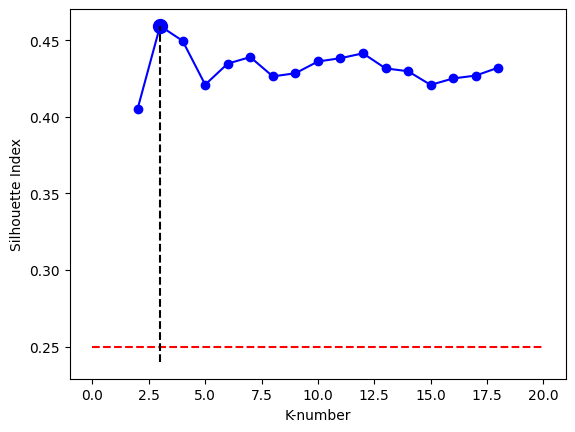

In [107]:
k = lknumber[lsilhouette.index(max(lsilhouette))]
best = max(lsilhouette)
plt.plot(lknumber, lsilhouette, color='blue', ls='-',
         marker='o')
plt.plot(np.linspace(0,20,20), [0.25]*20, color='red',ls="--")
plt.plot([k]*20, np.linspace(0.24, best, 20), color='k', ls='--')
plt.scatter(k, best, color='blue',
            s=100)
plt.xlabel('K-number')
plt.ylabel('Silhouette Index')
plt.savefig(f"./p3/silhouette.png", dpi=300)  # Increase the resolution


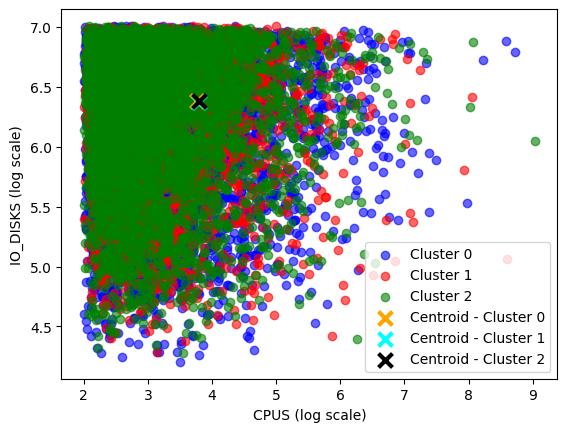

In [162]:
plt.scatter(np.log1p(df[df.cluster == 0]['CPUS'].values),
            np.log1p(df[df.cluster == 0]['IO_DISKS'].values), color='blue', label=f'Cluster 0', alpha=0.6)
plt.scatter(np.log1p(df[df.cluster == 1]['CPUS'].values),
            np.log1p(df[df.cluster == 1]['IO_DISKS'].values), color='red', label=f'Cluster 1', alpha=0.6)
plt.scatter(np.log1p(df[df.cluster == 2]['CPUS'].values),
            np.log1p(df[df.cluster == 2]['IO_DISKS'].values), color='green', label=f'Cluster 2', alpha=0.6)

# Agrupar as colunas numéricas de interesse e calcular a média
cluster_summary = df.groupby('cluster')[['CPUS', 'IO_DISKS']].mean()

# Converter as médias em logarítmica
cluster_summary_log = np.log1p(cluster_summary)

# Plotar os centróides dos clusters
plt.scatter(cluster_summary_log.loc[0, 'CPUS'], cluster_summary_log.loc[0, 'IO_DISKS'],
            color='orange', marker='x', s=100, label=f'Centroid - Cluster 0', lw=3)
plt.scatter(cluster_summary_log.loc[1, 'CPUS'], cluster_summary_log.loc[1, 'IO_DISKS'],
            color='cyan', marker='x', s=100, label=f'Centroid - Cluster 1', lw=3)
plt.scatter(cluster_summary_log.loc[2, 'CPUS'], cluster_summary_log.loc[2, 'IO_DISKS'],
            color='black', marker='x', s=100, label=f'Centroid - Cluster 2', lw=3)

plt.xlabel('CPUS (log scale)')
plt.ylabel('IO_DISKS (log scale)')
plt.legend()
plt.savefig(f"./p3/cluster_centroids_log_scale_cpusxios.png", dpi=300)  # Increase the resolution
plt.show()


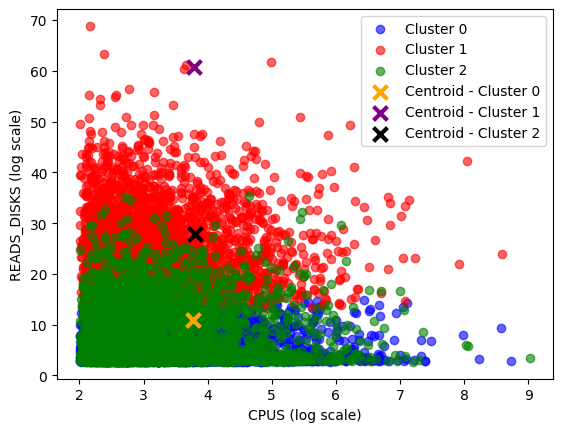

In [163]:
plt.scatter(np.log1p(df[df.cluster == 0]['CPUS'].values),
            np.log1p(df[df.cluster == 0]['READS_DISKS'].values), color='blue', label=f'Cluster 0', alpha=0.6)
plt.scatter(np.log1p(df[df.cluster == 1]['CPUS'].values),
            np.log1p(df[df.cluster == 1]['READS_DISKS'].values), color='red', label=f'Cluster 1', alpha=0.6)
plt.scatter(np.log1p(df[df.cluster == 2]['CPUS'].values),
            np.log1p(df[df.cluster == 2]['READS_DISKS'].values), color='green', label=f'Cluster 2', alpha=0.6)

# Agrupar as colunas numéricas de interesse e calcular a média
cluster_summary = df.groupby('cluster')[['CPUS', 'READS_DISKS']].mean()

# Converter as médias em logarítmica
cluster_summary_log = np.log1p(cluster_summary)

# Plotar os centróides dos clusters
plt.scatter(cluster_summary_log.loc[0, 'CPUS'], cluster_summary_log.loc[0, 'READS_DISKS'],
            color='orange', marker='x', s=100, label=f'Centroid - Cluster 0', lw=3)
plt.scatter(cluster_summary_log.loc[1, 'CPUS'], cluster_summary_log.loc[1, 'READS_DISKS'],
            color='purple', marker='x', s=100, label=f'Centroid - Cluster 1', lw=3)
plt.scatter(cluster_summary_log.loc[2, 'CPUS'], cluster_summary_log.loc[2, 'READS_DISKS'],
            color='black', marker='x', s=100, label=f'Centroid - Cluster 2', lw=3)

plt.xlabel('CPUS (log scale)')
plt.ylabel('READS_DISKS (log scale)')
plt.legend()
plt.savefig(f"./p3/cluster_centroids_log_scale_cpusxreads.png", dpi=300)  # Increase the resolution
plt.show()



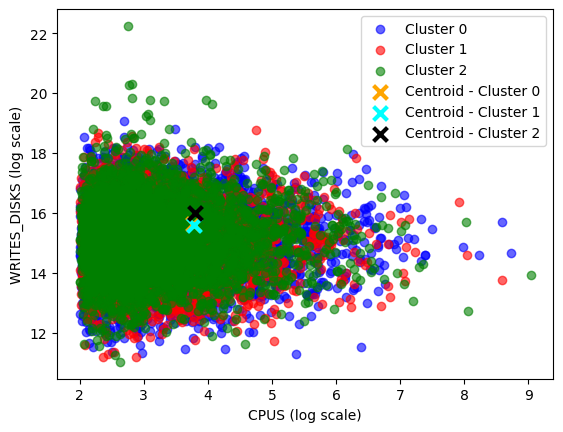

In [164]:
plt.scatter(np.log1p(df[df.cluster == 0]['CPUS'].values),
            np.log1p(df[df.cluster == 0]['WRITES_DISKS'].values), color='blue', label=f'Cluster 0', alpha=0.6)
plt.scatter(np.log1p(df[df.cluster == 1]['CPUS'].values),
            np.log1p(df[df.cluster == 1]['WRITES_DISKS'].values), color='red', label=f'Cluster 1', alpha=0.6)
plt.scatter(np.log1p(df[df.cluster == 2]['CPUS'].values),
            np.log1p(df[df.cluster == 2]['WRITES_DISKS'].values), color='green', label=f'Cluster 2', alpha=0.6)

# Agrupar as colunas numéricas de interesse e calcular a média
cluster_summary = df.groupby('cluster')[['CPUS', 'WRITES_DISKS']].mean()

# Converter as médias em logarítmica
cluster_summary_log = np.log1p(cluster_summary)

# Plotar os centróides dos clusters
plt.scatter(cluster_summary_log.loc[0, 'CPUS'], cluster_summary_log.loc[0, 'WRITES_DISKS'],
            color='orange', marker='x', s=100, label=f'Centroid - Cluster 0', lw=3)
plt.scatter(cluster_summary_log.loc[1, 'CPUS'], cluster_summary_log.loc[1, 'WRITES_DISKS'],
            color='cyan', marker='x', s=100, label=f'Centroid - Cluster 1', lw=3)
plt.scatter(cluster_summary_log.loc[2, 'CPUS'], cluster_summary_log.loc[2, 'WRITES_DISKS'],
            color='black', marker='x', s=100, label=f'Centroid - Cluster 2', lw=3)

plt.xlabel('CPUS (log scale)')
plt.ylabel('WRITES_DISKS (log scale)')
plt.legend()
plt.savefig(f"./p3/cluster_centroids_log_scale_cpusxwrites.png", dpi=300)  # Increase the resolution
plt.show()



In [160]:
dt0 = df[df.cluster == 0].describe()
dt0=dt0[clusterfeatures]
dt0.loc['cv']=dt0.loc['std'].values / dt0.loc['mean'].values
dt0.loc['range']=dt0.loc['max'].values - dt0.loc['min'].values
dt0.loc['median'] = dt0.median()
dt0.loc['total'] = dt0.sum()
dt0.loc['variance'] = dt0.var()
dt0

,CPUS,IO_DISKS,READS_DISKS,WRITES_DISKS
count,7316.0000,7316.0000,7316.0000,7316.0000
mean,42.2816,588.7921,56690.3383,6047266.0215
std,141.2613,273.7506,257473.2844,8709920.0281
min,6.4198,66.0000,13.2801,80632.8639
25%,11.3300,358.7500,21.6656,1615404.0435
50%,17.7918,588.0000,40.3265,3341187.4433
75%,34.2055,825.0000,882.9081,6903617.2591
max,6149.7223,1102.0000,3074387.5055,189172833.6615
cv,3.3410,0.4649,4.5417,1.4403
range,6143.3025,1036.0000,3074374.2254,189092200.7976


In [158]:
dt1 = df[df.cluster == 1].describe()
dt1=dt1[clusterfeatures]
dt1.loc['cv']=dt1.loc['std'].values/dt1.loc['mean'].values
dt1.loc['range']=dt1.loc['max'].values - dt1.loc['min'].values
dt1.loc['median'] = dt1.median()
dt1.loc['total'] = dt1.sum()
dt1.loc['variance'] = dt1.var()
dt1

,CPUS,IO_DISKS,READS_DISKS,WRITES_DISKS
count,3480.0000,3480.0000,3480.0000,3480.0000
mean,43.3243,584.5876,229849912733713366314385408.0000,5883414.5748
std,142.1828,271.5829,13490172805470094216963031040.0000,9142754.6063
min,6.4392,72.0000,308012.5105,71594.4129
25%,11.2520,353.0000,78436492.3387,1463057.7933
50%,17.9250,581.5000,5646050206.5882,3077744.7149
75%,34.6807,815.0000,2021774626554.2700,6617160.8146
max,5388.4228,1100.0000,795801351982491727878430916608.0000,140461314.3502
cv,3.2818,0.4646,58.6912,1.5540
range,5381.9837,1028.0000,795801351982491727878430916608.0000,140389719.9373


In [159]:
dt2 = df[df.cluster == 2].describe()
dt2=dt2[clusterfeatures]
dt2.loc['cv']=dt2.loc['std'].values/dt2.loc['mean'].values
dt2.loc['range']=dt2.loc['max'].values - dt2.loc['min'].values
dt2.loc['median'] = dt2.median()
dt2.loc['total'] = dt2.sum()
dt2.loc['variance'] = dt2.var()
dt2

,CPUS,IO_DISKS,READS_DISKS,WRITES_DISKS
count,4204.0000,4204.0000,4204.0000,4204.0000
mean,43.6919,589.4329,1342397994197.5095,8839105.4364
std,168.4463,272.8338,48534406671458.1484,74253663.7343
min,6.4101,71.0000,13.4266,61362.2486
25%,11.4593,357.0000,23.4576,1653330.4607
50%,18.0578,591.0000,65.9801,3548366.7103
75%,35.3487,828.0000,23134.7670,7476328.8667
max,8384.5980,1102.0000,2439098667384334.0000,4564575662.1354
cv,3.8553,0.4629,36.1550,8.4006
range,8378.1879,1031.0000,2439098667384320.5000,4564514299.8868
